In [10]:
DATA_FOLDER = "../../random-data/"
OUTPUT_FOLDER = "../../deliverables/injected/"
WINDOW_SIZE = 1024  # size in freq bins of injected signal

In [11]:
import setigen as stg

# from setigen_patch import setigen_patch as stg_patched
import blimpy as bl
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt

%matplotlib inline

from copy import deepcopy as dc

In [12]:
fil_filename = "guppi_60703_16858_008036_TIC286923464_ON_0001.0000.fil"

In [5]:
frame = stg.Frame(waterfall=DATA_FOLDER + fil_filename)

## Constant drifted

In [ ]:
min_freq_index = 400
dr = 1.1 * u.Hz / u.s
snr = 25

l = 42_689_571
r = l + WINDOW_SIZE

In [6]:
def make_frame_s(min_freq_index, dr, snr, l, r):
    frame_s = frame.get_slice(l, r)
    signal = frame_s.add_signal(
        stg.constant_path(
            f_start=frame_s.get_frequency(index=min_freq_index), drift_rate=dr
        ),
        stg.constant_t_profile(level=frame.get_intensity(snr=snr)),
        stg.gaussian_f_profile(width=100 * u.Hz),
        stg.constant_bp_profile(level=1),
    )
    return frame_s

In [7]:
frame_s = make_frame_s(min_freq_index, dr, snr, l, r)

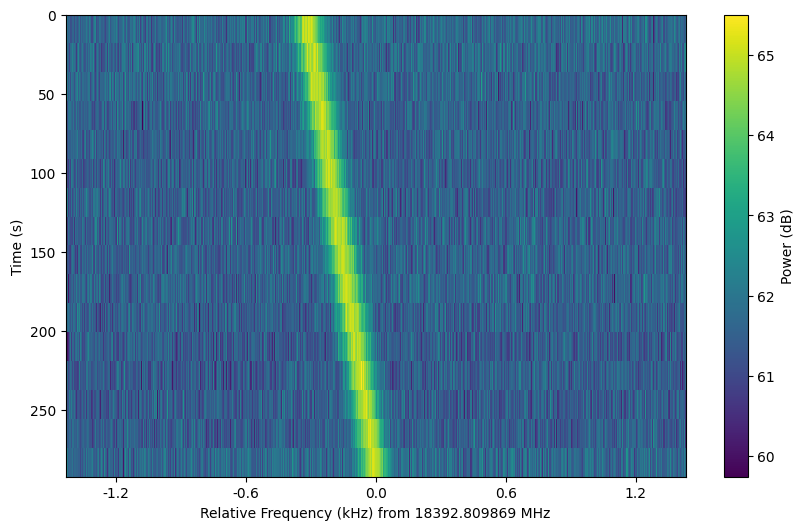

In [8]:
fig = plt.figure(figsize=(10, 6))
frame_s.plot(db=True)
plt.savefig(OUTPUT_FOLDER + "signal.png")

In [9]:
def modify_and_save(frame_s, frame, l, r, adj="", modify=True, save=True):
    frame_s.plot(db=True)
    if save:
        plt.savefig(OUTPUT_FOLDER + adj + ".png")
    if not modify:
        return
    old_data = dc(frame.data)
    frame.data[:, l:r] = frame_s.data
    frame.save_h5(
        OUTPUT_FOLDER + fil_filename[:-4] + f"{'.' + adj if adj!='' else ''}.h5"
    )
    frame.data = dc(old_data)

In [10]:
def modify_and_save(frame_s, frame, l, r, adj="", modify=True, save=True):
    frame_s.plot(db=True)

    if save:
        plt.savefig(OUTPUT_FOLDER + adj + ".png")

    if not modify:
        return

    try:
        old_data = dc(frame.data)
        # Check shapes and dtypes
        print("frame_s.data shape:", frame_s.data.shape)
        print("frame.data shape:", frame.data.shape)
        print("frame.data dtype:", frame.data.dtype)
        print("frame_s.data dtype:", frame_s.data.dtype)

        # In-place modify
        frame.data[:, l:r] = frame_s.data

        # Make sure it's a proper NumPy array
        assert isinstance(frame.data, np.ndarray), "frame.data is not a NumPy array"
        assert np.isfinite(frame.data).all(), "frame.data contains NaNs or infs"

        # Save
        filename = (
            OUTPUT_FOLDER + fil_filename[:-4] + (f".{adj}" if adj else "") + ".h5"
        )
        frame.save_h5(filename)
    except Exception as e:
        print("Failed to modify and save frame:", e)
    finally:
        # Restore original data
        frame.data = old_data

frame_s.data shape: (16, 1024)
frame.data shape: (16, 67108864)
frame.data dtype: float32
frame_s.data dtype: float32
blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for ../../deliverables/injected/guppi_60703_16858_008036_TIC286923464_ON_0001.0000.h5 without blobbing.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
Failed to modify and save frame: Unable to synchronously create dataset (error during user callback)


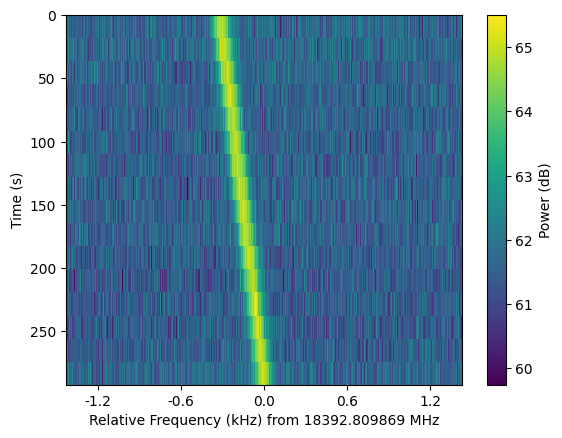

In [11]:
modify_and_save(frame_s, frame, l, r)

I tried running both the file with the added signal and the one without using `seticore`, and the result is the same. I could try increasing the SNR either here or in `seticore`. It would be easier with the latter, but I'm doing it from here because even if it takes longer, it will be easier to check the differences afterward.

frame_s.data shape: (16, 1024)
frame.data shape: (16, 67108864)
frame.data dtype: float32
frame_s.data dtype: float32
blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for ../../deliverables/injected/guppi_60703_16858_008036_TIC286923464_ON_0001.0000.strong.h5 without blobbing.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
Failed to modify and save frame: Unable to synchronously create dataset (error during user callback)


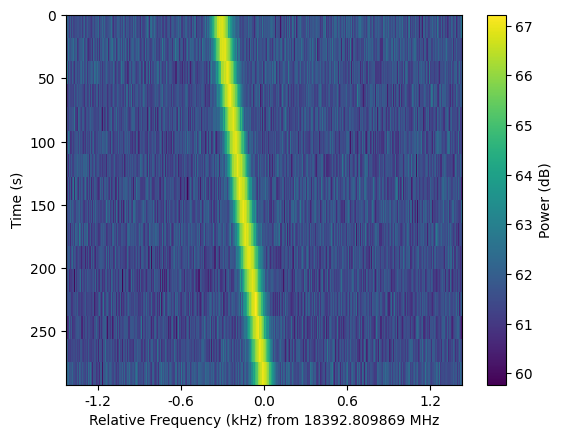

In [12]:
frame_s = make_frame_s(min_freq_index, dr, 2 * snr, l, r)
modify_and_save(frame_s, frame, l, r, "strong")

frame_s.data shape: (16, 1024)
frame.data shape: (16, 67108864)
frame.data dtype: float32
frame_s.data dtype: float32
blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for ../../deliverables/injected/guppi_60703_16858_008036_TIC286923464_ON_0001.0000.mighty.h5 without blobbing.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
Failed to modify and save frame: Unable to synchronously create dataset (error during user callback)


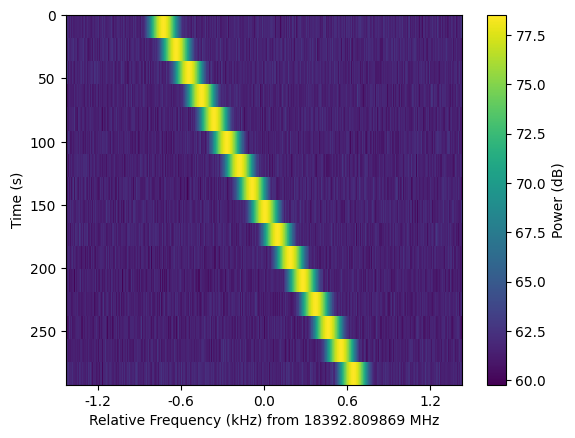

In [13]:
frame_s = make_frame_s(251, 5 * u.Hz / u.s, 1e3, l, r)
modify_and_save(frame_s, frame, l, r, "mighty")

## Random injection

In [15]:
OLD_FRAME_DATA = frame.data.copy()
FOLDER_GRID = OUTPUT_FOLDER + "parameter search"
L = np.linspace(0, frame.data.shape[1] - WINDOW_SIZE, 50, dtype=int)
DR = np.linspace(-5, 5, 100)
MFI = (WINDOW_SIZE * frame.df - frame.data.shape[0] * frame.dt * DR) / (2 * frame.df)
SNR = 10 ** np.linspace(0, 3, 200)

In [8]:
index_dr = np.random.randint(DR.size)
l = np.random.choice(L)
snr = np.random.choice(SNR)
mfi = np.round(MFI[index_dr])
dr = DR[index_dr]
r = l + WINDOW_SIZE
mfi, dr, snr, l

(np.float64(657.0),
 np.float64(-2.7777777777777777),
 np.float64(4.008806328898465),
 np.int64(42455980))

In [9]:
frame_s = make_frame_s(mfi, dr, snr, l, r)

In [10]:
frame.data[:, l:r] = frame_s.data

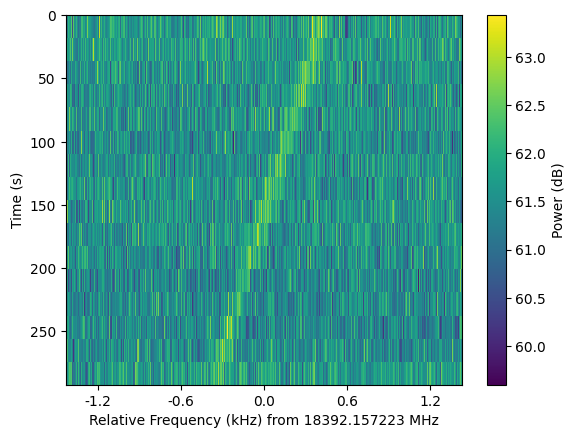

In [11]:
frame_s.plot()

In [13]:
frame.save_h5("test.h5")

blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for test.h5 without blobbing.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.


ValueError: Unable to synchronously create dataset (error during user callback)

## Weird

In [ ]:
from utils.osea_signal import osea_path as osea_path

In [ ]:
frame_s = frame.get_slice((l := 42_689_571), (r := l + WINDOW_SIZE))

In [ ]:
signal = frame_s.add_signal(
    osea_path(
        f_start=frame_s.get_frequency(index=200),
        drift_rate=3,
        amplitude=1_000,
        omega=0.07,
        mu=0.005,
    ),
    stg.constant_t_profile(level=frame.get_intensity(snr=20)),
    stg.gaussian_f_profile(width=100 * u.Hz),
    stg.constant_bp_profile(level=1),
)

In [ ]:
fig = plt.figure(figsize=(10, 6))
frame_s.plot(db=True)

In [ ]:
modify_and_save(frame_s, frame, l, r, "weird")